# Data analysis and visualization

In this notebook I continue the analysis and visualization of the data cleaned in `1_cleaning.ipynb`. 

In [181]:
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import networkx as nx
from networkx.algorithms import community
import community as community_louvain
import collections

In [182]:
df = pd.read_csv("data/data_cleaned.csv")

A couple of the visuals involve votes to and from Turkey. The code below prepares the data for the visualizations. They were made in rawgraphs and edited in illustrator.

In [183]:
# get a dataframe where the to_country and from_country are either Türkiye, France, Netherlands, Germany or Belgium
turkey_df = df[(df['from_country'].isin(['France', 'Germany', 'Netherlands', 'Belgium', 'Türkiye'])) & (df['to_country'].isin(['France', 'Germany', 'Netherlands', 'Belgium', 'Türkiye']))]


# Group by to_country and from_country and get the sum of total_points
turkey_df = turkey_df.groupby(['to_country', 'from_country'])['total_points'].sum().reset_index()

# Drop the row if Türkiye is not either the to_country or the from_country
turkey_df = turkey_df[(turkey_df['to_country'] == 'Türkiye') | (turkey_df['from_country'] == 'Türkiye')]

In [184]:
turkey = df[(df['from_country'] == 'Türkiye') | (df['to_country'] == 'Türkiye')]

# Group by to_country and from_country and get the sum of total_points
turkey = turkey.groupby(['to_country', 'from_country'])['total_points'].sum().reset_index()

turkey.to_csv('data/turkey_supporters.csv', index=False)

turkey.to_clipboard()

In [185]:
# Find all the rows where from_country is either France, Germany, Netherlands, Belgium or Austria and to_country is Türkiye

tu = df[(df['from_country'].isin(['France', 'Germany', 'Netherlands', 'Belgium'])) & (df['to_country'] == 'Türkiye')]

# Get the mean of total_points for each year and from_country
tu['mean'] = tu.groupby(['year', 'from_country'])['total_points'].transform('mean')

tu.to_csv('data/turkey_supporters.csv', index=False)

## Visualizations

Some of the visualizations in the project is made in rawgraphs, other using ggplot. The code for the ggplots are provided below. 

In [186]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [187]:
%%R

require('tidyverse')
library('flextable')
library('GGally')
library('ggraph')
library('gutenbergr')
library('igraph')
library('Matrix')
library('network')
library('quanteda')
library('sna')
library('tidygraph')
library('tidyverse')
library('tm')
library('tibble')
library('svglite')
# activate klippy for copy-to-clipboard button
klippy::klippy()

<script>
  addClassKlippyTo("pre.r, pre.markdown");
  addKlippy('left', 'top', 'auto', '1', 'Copy code', 'Copied!');
</script>


In [188]:
contestants = pd.read_csv('data/contestants.csv')

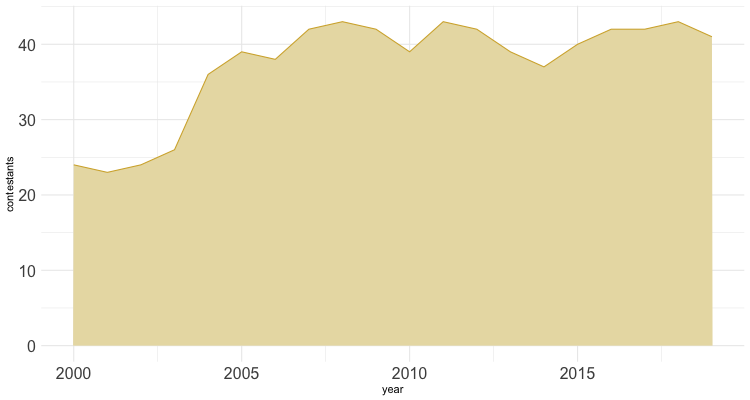

In [189]:
%%R -i contestants -w 750 -h 400

ggplot(contestants, aes(x=year, y=contestants)) +
    geom_area(color="#d4af37", fill="#E9DDB1") + 
    theme_minimal() +
    theme(axis.text.x = element_text(size = 16),
    axis.text.y = element_text(size = 16)) +
    scale_x_continuous(breaks = seq(1960, 2015, by = 5))


#ggsave(file="visuals/years1.svg")

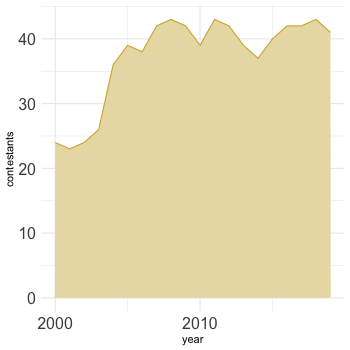

In [190]:
%%R -i contestants -w 350 -h 350

ggplot(contestants, aes(x=year, y=contestants)) +
    geom_area(color="#d4af37", fill="#E9DDB1") + 
    theme_minimal() +
    theme(axis.text.x = element_text(size = 16),
    axis.text.y = element_text(size = 16)) +
    scale_x_continuous(breaks = seq(1960, 2015, by = 10))


#ggsave(file="visuals/years2.svg")

In [192]:
turkey = pd.read_csv('data/turkey.csv')

# Drop rows before 2000
turkey = turkey[turkey['year'] >= 2000]

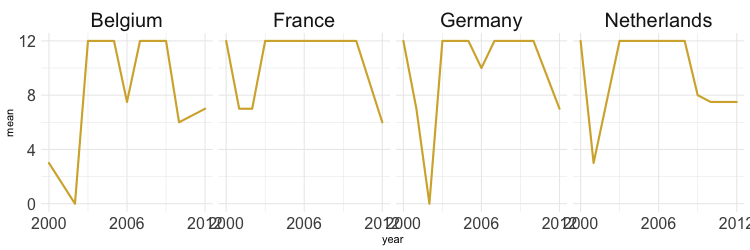

In [193]:
%%R -i turkey -w 750 -h 250

ggplot(turkey, aes(x = year, y=mean)) +
    geom_line(color="#d4af37", size=1, lineend = "round") +
    facet_wrap(~from_country, ncol=4) +
    theme_minimal() +
    theme(axis.text.x = element_text(size = 16),
    axis.text.y = element_text(size = 16),
    strip.text.x = element_text(size = 20)) +
    scale_x_continuous(breaks = seq(2000, 2012, by = 6)) +
    scale_y_continuous(breaks = seq(0, 12, by = 4))

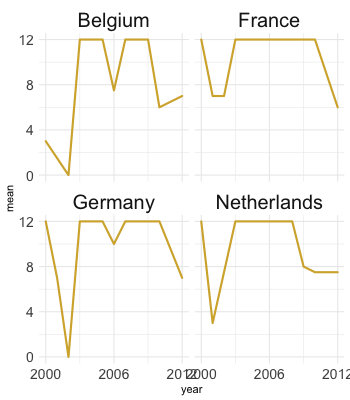

In [ ]:
%%R -i turkey -w 350 -h 400

ggplot(turkey, aes(x = year, y=mean)) +
    geom_line(color="#d4af37", size=1, lineend = "round") +
    facet_wrap(~from_country, ncol=2) +
    theme_minimal() +
    theme(axis.text.x = element_text(size = 14),
    axis.text.y = element_text(size = 14),
    strip.text.x = element_text(size = 20)) +
    scale_x_continuous(breaks = seq(2000, 2012, by = 6)) +
    scale_y_continuous(breaks = seq(0, 12, by = 4))

In [ ]:
df = pd.read_csv("data/to_from_turkey.csv")

df = df.dropna()

# create a new column called difference

df['difference'] = df['from_turkey'] - df['to_turkey']

In [ ]:
df_long = pd.melt(
    df,
    id_vars=['country', 'difference'],
    var_name='to_from',
    value_name='votes'
)

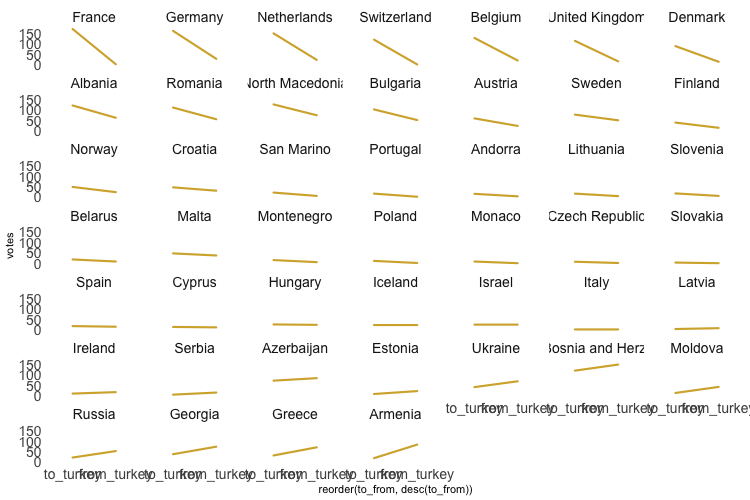

In [ ]:
%%R -i df_long -w 750 -h 500

ggplot(df_long, aes(x = reorder(to_from, desc(to_from)), y = votes, group = country)) +
    geom_line(color="#d4af37", size=1, lineend = "round") +
    facet_wrap(~reorder(country, difference)) + 
    theme_minimal() +
    theme(axis.text.x = element_text(size = 14),
    axis.text.y = element_text(size = 14),
    strip.text.x = element_text(size = 14),
    panel.grid.major = element_blank(), 
    panel.grid.minor = element_blank())


#ggsave(file="visuals/all_turkey1.svg")

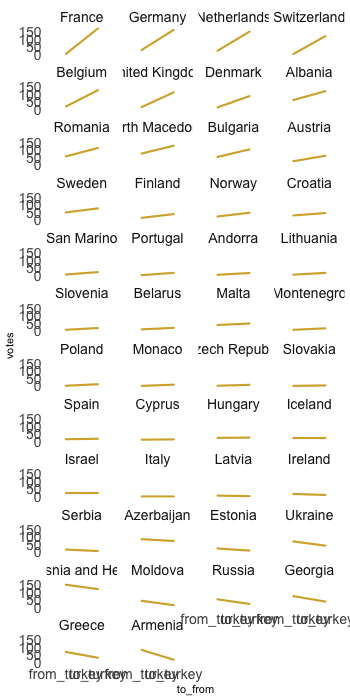

In [ ]:
%%R -i df_long -w 350 -h 700

ggplot(df_long, aes(x = to_from, y = votes, group = country)) +
    geom_line(color="#d4af37", size=1, lineend = "round") +
    facet_wrap(~reorder(country, difference), ncol=4) + 
    theme_minimal() +
    theme(axis.text.x = element_text(size = 14),
    axis.text.y = element_text(size = 14),
    strip.text.x = element_text(size = 14),
    panel.grid.major = element_blank(), 
    panel.grid.minor = element_blank())

#ggsave(file="visuals/all_turkey_mobile.svg")

## Measuring network tightness

Below I run an exploratory analysis of the natural voting groupings within the Eurovision using the [Louvain method for community detection](https://en.wikipedia.org/wiki/Louvain_method).

In [ ]:
data = pd.read_csv('all_data.csv')

In [ ]:
# Only keep the columns from_country, to_country, and mean
to_from = data[['from_country', 'to_country', 'mean']]

In [ ]:
to_from = pd.pivot(to_from, index='from_country', columns='to_country', values='mean')

# Fill NaN with 0
to_from = to_from.fillna(0)

In [ ]:
#Find louvian groups
np_matrix = to_from.values
names = to_from.columns
print(names)
G = nx.from_numpy_array(np_matrix)
G = nx.relabel_nodes(G, dict(enumerate(names)))
partition = community_louvain.best_partition(G)

Index(['Albania', 'Andorra', 'Armenia', 'Australia', 'Austria', 'Azerbaijan',
       'Belarus', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic',
       'Denmark', 'Estonia', 'Finland', 'France', 'Georgia', 'Germany',
       'Greece', 'Hungary', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Latvia',
       'Lithuania', 'Malta', 'Moldova', 'Monaco', 'Montenegro', 'Netherlands',
       'North Macedonia', 'Norway', 'Poland', 'Portugal', 'Romania', 'Russia',
       'San Marino', 'Serbia', 'Slovakia', 'Slovenia', 'Spain', 'Sweden',
       'Switzerland', 'Türkiye', 'Ukraine', 'United Kingdom'],
      dtype='object', name='to_country')


In [ ]:
#Asign groups on pandaframe
partition = collections.OrderedDict(sorted(partition.items())) 
to_from['group'] = partition.values()
to_from = to_from.sort_values(by ='group')

In [ ]:
#Calculate Asymmetry of each nation
df = pd.DataFrame(columns=list(['Name', 'Asymmetry']))
for i in range(0, np_matrix.shape[0]):
    total = 0
    for k in range(0, np_matrix.shape[0]):
        total += np.abs(np_matrix[i,k] - np_matrix[k,i])
    df = df.append({'Name' : to_from.axes[0][i], 'Asymmetry' : total/np_matrix.shape[0]}, ignore_index=True)
df = df.sort_values(by=['Asymmetry'])

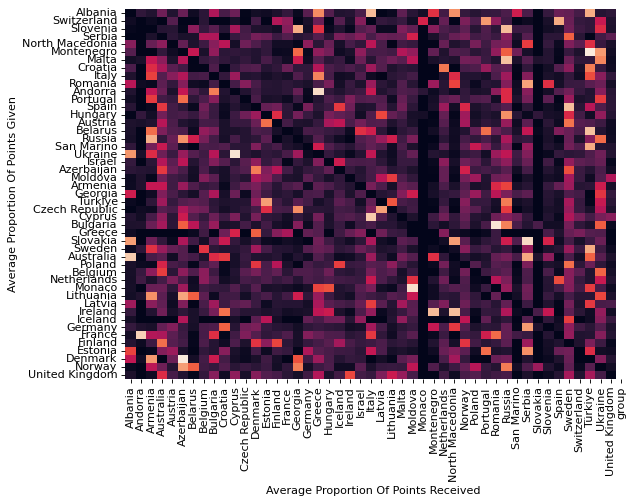

In [ ]:
#Create heatmap
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
x_axis_labels = to_from.axes[1] # labels for x-axis
y_axis_labels = to_from.axes[0] # labels for y-axis
sns.heatmap(np_matrix, xticklabels=x_axis_labels, yticklabels=y_axis_labels,cbar=False)
plt.xlabel("Average Proportion Of Points Received")
plt.ylabel("Average Proportion Of Points Given")
plt.show()